# Scalability of distributed algorithms

<a id='intro'></a>
## Models of computation and communication
Lets consider bulk synchronous parallel processing model. Time of one iteration consists of computation and communication times that depend on the number of operations C, data D and number of nodes n.
<code>
  *T = t<sub>cp</sub> + t<sub>cm</sub>*
  *t<sub>cp</sub>(n,C) = Cf(n)*
  *t<sub>cm</sub>(n,D) = Dg(n)*
</code>  
  
In the most simple case, <code>f(n)</code> depends on the number of nodes inversely, i.e.
<code> 
  *t<sub>cp</sub> = C/n*
</code>
This case can be attributed to as "data parallelism". We will consider "model parallelism" further.

Communication can be all-to-all, i.e. each node needs an update from every other node:
<code> 
  *t<sub>cm</sub> = Dn*
</code>
In some cases it can be all-reduce or tree-aggregation:
<code> 
  *t<sub>cm</sub> = Dlog(n)*
</code>


In [1]:
import math
def t_cp(n, c):
    return c / n
def t_cm(n, d):
    return d * math.log (n, 2)
def t_cmlin(n, d):
    return d * n
def t_total(n, c, d):
    return t_cp(n, c) + t_cm(n, d)
def t_lin(n, c, d):
    return t_cp(n, c) + t_cmlin(n, d)

Lets plot graphs to see how the total time behave depending on the number of nodes:

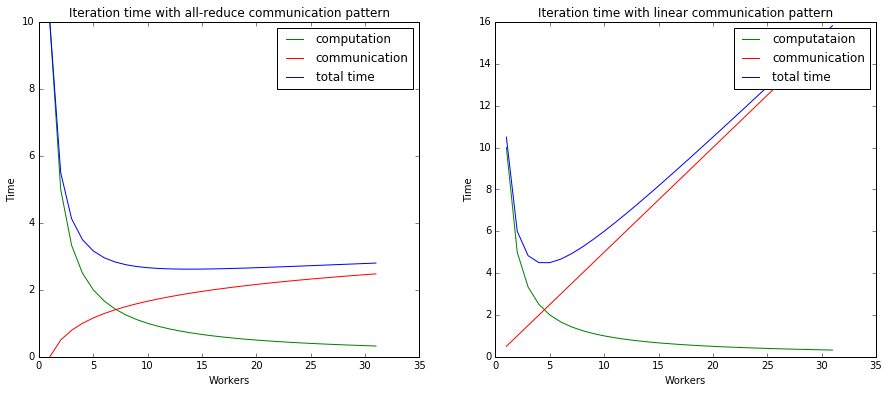

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
n = np.arange(1, 32)
c = 10
d = 0.5
tcpData = np.vectorize(t_cp)(n, c)
tcmData = np.vectorize(t_cm)(n, d)
tData = np.vectorize(t_total)(n, c, d)
sData = np.vectorize(speedup)(n, c, d)
tcmlinData = np.vectorize(t_cmlin)(n, d)
tlinData = np.vectorize(t_lin)(n, c, d)
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
leg1, = plt.plot(n,tcpData, color="green", label='computation')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time with all-reduce communication pattern")
plt.legend(handles=[leg1, leg2, leg3])
plt.subplot(122)
leg1, = plt.plot(n, tcpData, color="green", label='computataion')
leg2, = plt.plot(n, tcmlinData, color="red", label='communication')
leg3, = plt.plot(n, tlinData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time with linear communication pattern")
plt.legend(handles=[leg1, leg2, leg3])

One can see that:
  - There is an optimal number of nodes that provides the minimal total time.
  - Total time for all-reduce communication pattern has smooth shape, i.e. one can use less than optimal nodes and still get near to minimal time
  - All-reduce communication has better scalability than all-to-all

Lest study these models on examples of various machine learning algorithms.

## Effectiveness of parallel processing
Parallel processing framework suggests several measures to estimate the effectiveness of parallel algorithms [1, 2]. Among them:
<code>
  *T(n)*  - execution time with *n* processors
  *S(n) = T(1)/T(n)*  - speedup
  *E(n) = S(n)/n* - efficiency
</code>
Lets consider these measures and discuss them. If *T(1)* is an approximation then the ratio *T(1)/T(n)* might become unreliable with *n>>1*. We propose to use another measure, called iterative speedup:
<code>
  *I(n, i) = S(n)/S(n-i)=T(n-i)/T(n)*  - iterative speedup
</code>

In [86]:
def speedup(n, c, d):
    return t_total(1, c, d) / t_total(n, c, d)
def efficiency(n, c, d):
    return speedup(n, c, d) / n
def ispeedup(n, c, d):
    return t_total(n - 1, c, d) / t_total(n, c, d)

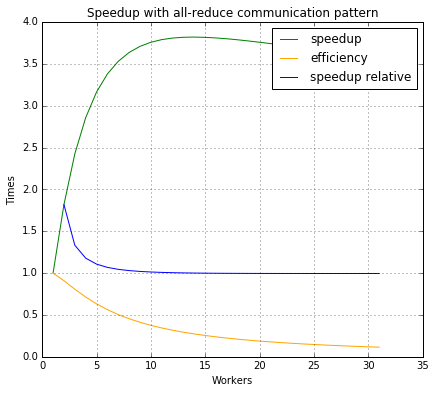

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
n = np.arange(1, 32)
r = np.arange(2, 32)
c = 10
d = 0.5
sData = np.vectorize(speedup)(n, c, d)
srelData = np.vectorize(ispeedup)(r, c, d)
slopeData = np.vectorize(speedup_slope)(r, c, d)
eData = np.vectorize(efficiency)(n, c, d)
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
ax = plt.gca()
ax.grid(True)
leg1, = plt.plot(n, sData, color="green", label='speedup')
leg2, = plt.plot(n, eData, color="orange", label='efficiency')
leg3, = plt.plot(r, srelData, color="blue", label='speedup relative')
plt.ylabel("Times")
plt.xlabel("Workers")
plt.title("Speedup with all-reduce communication pattern")
plt.legend(handles=[leg1, leg2, leg3])

In [85]:
print("Time and speedup at 10 nodes:", t_total(10, c, d), speedup(10, c, d))
print("Time and speedup at 15 nodes:", t_total(15, c, d), speedup(15, c, d))

Time and speedup at 10 nodes: 2.6609640474436813 3.7580364941821514
Time and speedup at 15 nodes: 2.620111964470926 3.816630791203337


## References
  1. Jada, Joseph. An introduction to parallel algorithms. addison Wesley, 1992.
  2. Parhami, Behrooz. Introduction to parallel processing: algorithms and architectures. Springer Science & Business Media, 2006.